## Cường độ, thời gian kéo dài và tần suất của các trận mưa có đặc điểm gì?

### 1. Ý nghĩa của việc trả lời câu hỏi
- Hiểu bản chất mưa của khu vực: xác định mưa ngắn hay dài, nhẹ hay mạnh, xảy ra thường xuyên hay theo mùa → tạo nên đặc trưng khí hậu mưa

- Nhận diện quy luật mưa: từ đặc điểm mưa có thể xác định mùa nào mưa nhiều, mùa nào mưa ít, thời điểm mưa trong năm, và cách mưa phân bố theo thời gian

- Đánh giá sự ổn định và biến thiên khí hậu: nhận biết tính mùa vụ, các bất thường so với trung bình nhiều năm và xu thế biến đổi dài hạn của lượng mưa

- Làm đầu vào cho mô hình dự báo: giúp cải thiện mô hình dự báo mưa ngắn hạn/dự báo theo mùa nhờ hiểu đặc trưng mưa của từng vùng

### 2. Phân tích dữ liệu trả lời câu hỏi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

# load dữ liệu
df = pd.read_csv('../data/processed/hcm_weather_processed.csv')

# xử lý sơ bộ dữ liệu
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['location_id', 'datetime'])

In [2]:
# xác định những dòng ghi nhận thời điểm có mưa (>0.1mm)
RAIN_THRESHOLD = 0.1
df['is_raining'] = df['precipitation (mm)'] >= RAIN_THRESHOLD

# xác định các cơn mưa (gom những dòng có mưa liên tục vào 1 cơn mưa)
df['block_id'] = (
    (df['is_raining'] != df['is_raining'].shift()) |
    (df['location_id'] != df['location_id'].shift())
).cumsum()

# tạo df chứa thông tin các trận mưa
rain_events = df[df['is_raining']].groupby('block_id').agg(
    start_time=('datetime', 'min'),
    duration_hours=('datetime', 'count'),
    total_rainfall=('precipitation (mm)', 'sum'),
    max_intensity=('precipitation (mm)', 'max'),
    month=('month', 'first')
).reset_index()

# phân loại mức độ mưa
def categorize_rain(mm):
    if mm < 2.5: return 'Mưa Nhỏ (<2.5mm)'
    elif mm < 10: return 'Mưa Vừa (2.5-10mm)'
    elif mm < 50: return 'Mưa To (10-50mm)'
    else: return 'Mưa Rất To (>50mm)'

rain_events['intensity_class'] = rain_events['max_intensity'].apply(categorize_rain)

In [3]:
# xét xem ngày nào là "ngày mưa" trong số những ngày có mưa
df['date'] = df['datetime'].dt.date
daily_rain = df.groupby(['location_id', 'date'])['precipitation (mm)'].sum().reset_index()
daily_rain['is_rainy_day'] = daily_rain['precipitation (mm)'] >= 1.0 # 1mm threshold for a "rainy day"

# chuẩn hoá lượng mưa trung bình của những "ngày mưa" (8 vị trí, 2 năm)
factor = 8 * 2
monthly_rainy_counts = daily_rain[daily_rain['is_rainy_day']].groupby(pd.to_datetime(daily_rain['date']).dt.month)['date'].count()
monthly_rainy_days_avg = monthly_rainy_counts / factor

# số lượng các trận mưa theo mức độ
freq_counts = rain_events['intensity_class'].value_counts()
# số lượng trận mưa to
heavy_rain_count = len(rain_events[rain_events['max_intensity'] >= 10])

# chu kỳ mưa: tổng thời gian theo dõi / tổng số cơn mưa (trung bình 1 trạm)
n_locations = df['location_id'].nunique()
total_hours = len(df) / n_locations  # tổng giờ gian theo dõi tại 1 trạm
total_events = len(rain_events) / n_locations # tổng số trận mưa tại 1 trạm
interval = total_hours / total_events if total_events > 0 else 0

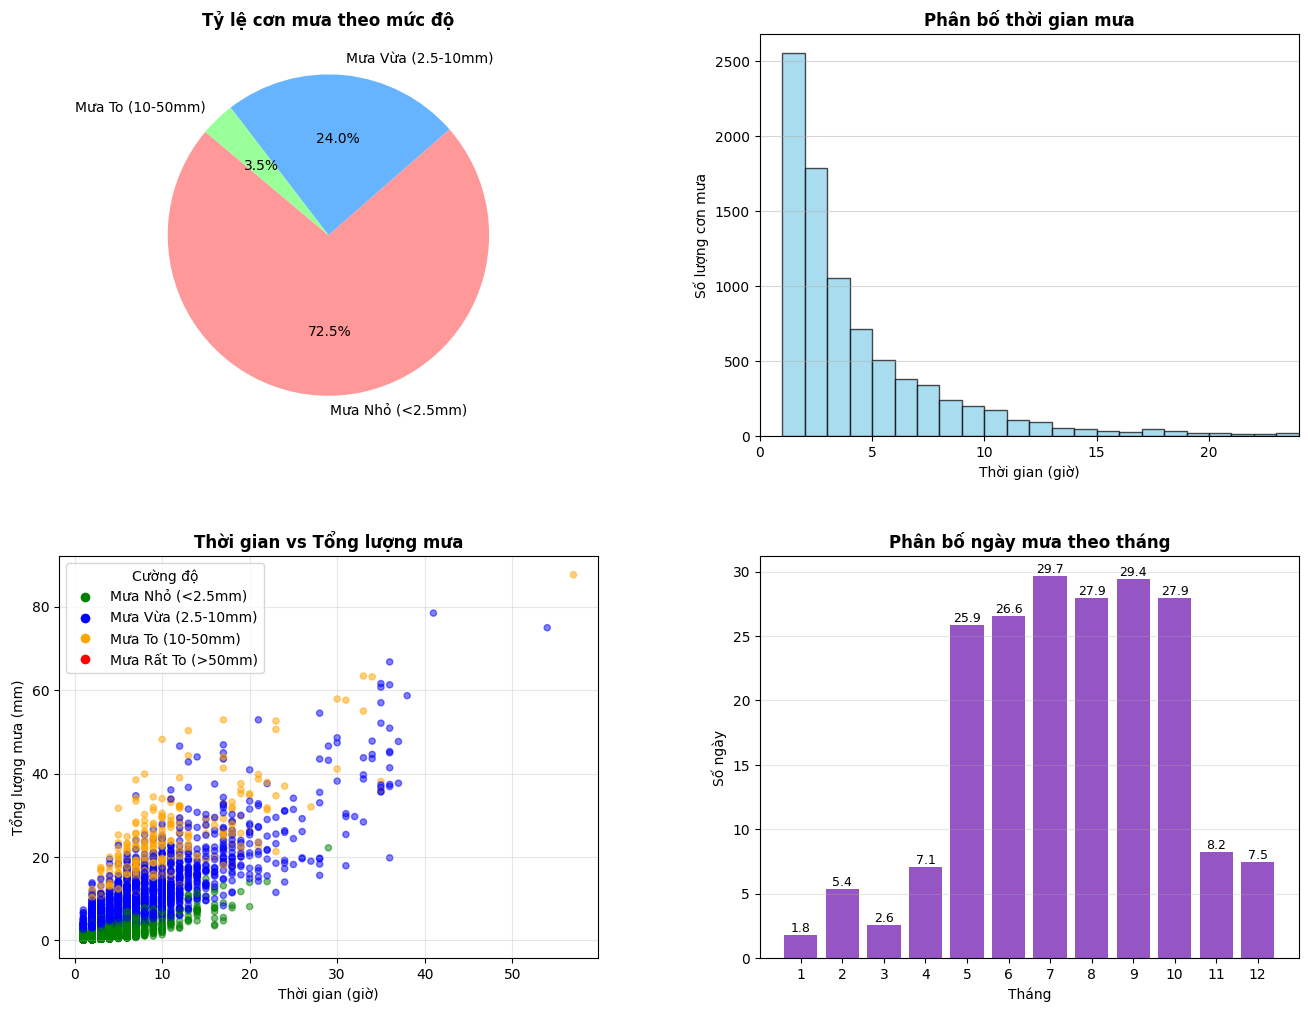

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Pie chart: biểu đồ tỉ lệ các cơn mưa theo mức độ
intensity_counts = rain_events['intensity_class'].value_counts()
colors_pie = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
axes[0, 0].pie(intensity_counts, labels=intensity_counts.index, autopct='%1.1f%%',
               startangle=140, colors=colors_pie)
axes[0, 0].set_title('Tỷ lệ cơn mưa theo mức độ', fontsize=12, fontweight='bold')

# Histogram: phân bố thời gian kéo dài mỗi cơn mưa
axes[0, 1].hist(rain_events['duration_hours'], bins=range(1, 25), color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Phân bố thời gian mưa', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Thời gian (giờ)')
axes[0, 1].set_ylabel('Số lượng cơn mưa')
axes[0, 1].set_xlim(0, 24)
axes[0, 1].grid(axis='y', alpha=0.5)

# Scatter plot: tương quan giữa thời gian và tổng lượng mưa
color_map = {'Mưa Nhỏ (<2.5mm)': 'green', 'Mưa Vừa (2.5-10mm)': 'blue', 'Mưa To (10-50mm)': 'orange', 'Mưa Rất To (>50mm)': 'red'}
colors_scatter = rain_events['intensity_class'].map(color_map)

axes[1, 0].scatter(rain_events['duration_hours'], rain_events['total_rainfall'],
                   c=colors_scatter, alpha=0.5, s=20)
axes[1, 0].set_title('Thời gian vs Tổng lượng mưa', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Thời gian (giờ)')
axes[1, 0].set_ylabel('Tổng lượng mưa (mm)')
axes[1, 0].grid(True, alpha=0.3)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=8) for k, v in color_map.items()]
axes[1, 0].legend(handles=legend_elements, title="Cường độ")

# Bar chart: phân bố ngày mưa theo tháng
months = monthly_rainy_days_avg.index
values = monthly_rainy_days_avg.values
bars = axes[1, 1].bar(months, values, color='#6a0dad', alpha=0.7)
axes[1, 1].set_title('Phân bố ngày mưa theo tháng', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tháng')
axes[1, 1].set_ylabel('Số ngày')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)

plt.show()

In [5]:
# chi tiết thống kê thời gian mưa
rain_events['duration_hours'].describe()

count    8530.000000
mean        4.063540
std         4.526049
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        57.000000
Name: duration_hours, dtype: float64

In [6]:
print(f"Tổng số trận mưa phân tích: {len(rain_events)}")
print(f"Thời gian mưa trung bình: {rain_events['duration_hours'].mean():.2f} giờ")
print(f"Cường độ lớn nhất ghi nhận: {rain_events['max_intensity'].max()} mm/h")

print(f"\nChu kỳ lặp lại trung bình: Cứ {interval:.1f} giờ có 1 trận mưa")
print(f"Tần suất mưa to (>10mm/h): {heavy_rain_count} trận (Chiếm {heavy_rain_count/len(rain_events)*100:.1f}%)")

Tổng số trận mưa phân tích: 8530
Thời gian mưa trung bình: 4.06 giờ
Cường độ lớn nhất ghi nhận: 24.7 mm/h

Chu kỳ lặp lại trung bình: Cứ 15.1 giờ có 1 trận mưa
Tần suất mưa to (>10mm/h): 296 trận (Chiếm 3.5%)


#### NHẬN XÉT

#### a. Về cường độ mưa

- Từ pie chart, ta thấy phần lớn các trận mưa có cường độ trung bình thấp --> mưa chủ yếu là mưa nhỏ và vừa

- Cường độ mưa được ghi nhận cao nhất là 24.7 mm/h, là mức mưa to

- Phân bố cường độ mưa:

  - Mưa nhỏ (<2.5mm/h): Chiếm đa số

  - Mưa vừa (2.5 - 10mm/h): Phổ biến trung bình

  - Mưa to (>10mm/h): Ít gặp hơn, thường là các cơn dông nhiệt ngắn

#### b. Về độ dài cơn mưa

- Thời gian trung bình: một trận mưa ở các khu vực kéo dài trung bình khoảng 4.06 giờ.

- Phân bố:

  - 25% số trận mưa chỉ kéo dài 1 giờ

  - 50% số trận mưa kéo dài dưới 2 giờ

  - 75% số trận mưa kéo dài dưới 5 giờ

Ta thấy mưa ở đây có đặc điểm là nhanh đến nhanh đi (đặc trưng của mưa dông nhiệt đới). Những trận mưa dầm dề cả ngày rất hiếm

#### c. Về tần suất mưa

- Tổng số trận mưa: 8,530 cơn mưa tách biệt trên 8 trạm đo được ghi nhận trong suốt giai đoạn 2024-2025

- Tần suất xuất hiện dày đặc vào các tháng mùa mưa (Tháng 5 - 11)

- Tháng 7,8,9,10 thường có số lượng ngày mưa nhiều nhất

- Các tháng mùa khô (ví dụ như tháng 1, 2, 3) số lượng ngày mưa rất ít so với những tháng mùa mưa

### 3. Kết luận rút ra:

Đặc trưng khí hậu: 
- Mưa tại đây mang tính chất điển hình của mưa dông nhiệt đới. Đặc điểm nhận dạng là tần suất cao vào mùa mưa (Tháng 5-11), nhưng thời gian mưa ngắn (50% dưới 2 giờ) và "nhanh đến nhanh đi". Hiện tượng mưa dầm dề kéo dài nhiều ngày là rất hiếm gặp

Về cường độ và rủi ro ngập: 
- Cường độ mưa chủ yếu ở mức nhỏ và vừa (<10mm/h). Cường độ cực đại ghi nhận được là ~25mm/h (mưa to), chưa đạt đến mức mưa rất to/cực đoan (>50mm/h)

Nhận định bổ sung:

- Nếu khu vực xảy ra ngập úng, nguyên nhân có thể không hoàn toàn do lượng mưa trút xuống quá lớn, mà chịu tác động cộng hưởng từ hạ tầng thoát nước chưa đáp ứng kịp thời hoặc yếu tố triều cường.

- Với đặc tính mưa ngắn (đa số < 2 giờ), chiến lược tốt nhất cho người dân khi gặp mưa là trú ẩn và chờ đợi, thay vì cố gắng di chuyển trong mưa, vì xác suất tạnh ráo sau 60-90 phút là rất cao

- Các tháng 9, 10 là cao điểm của mùa mưa, cần có kế hoạch dự phòng cho giao thông và các hoạt động ngoài trời
